# Speech Emotion Recognition Project

In [3]:
# Import 
import pandas as pd
import numpy as np
import os
import sys
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from IPython.display import Audio
import keras
import np_utils
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
# Reproducibility
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)

In [14]:
# Path to the TESS dataset
tess = '/workspaces/Zidio-Internship/Data/tess toronto emotional speech set data/TESS Toronto emotional speech set data'
directory_list = os.listdir(tess)

file_emotion = []
file_path = []

# Loop through directories and files to extract emotion labels and file paths
for dir in directory_list:
    dir_path = os.path.join(tess, dir)
    
    if os.path.isdir(dir_path):
        files = os.listdir(dir_path)
        
        for file in files:
            part = file.split('_')[-1]
            part = part.split('.')[0]

            # Handle special case for 'ps' emotion label
            if part == 'ps':
                file_emotion.append('surprise')
            else:
                file_emotion.append(part)
                
            file_path.append(os.path.join(dir_path, file))

# Combine emotion and path data into a single DataFrame
emotion_df = pd.DataFrame(file_emotion, columns=['emotions'])
path_df = pd.DataFrame(file_path, columns=['path'])
tess_df = pd.concat([emotion_df, path_df], axis=1)
tess_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   emotions  2800 non-null   object
 1   path      2800 non-null   object
dtypes: object(2)
memory usage: 43.9+ KB


In [15]:
tess_df['emotions'].unique()

array(['surprise', 'disgust', 'neutral', 'happy', 'sad', 'angry', 'fear'],
      dtype=object)

## Data Visualisation and Exploration

First let's plot the count of each emotions in our dataset.

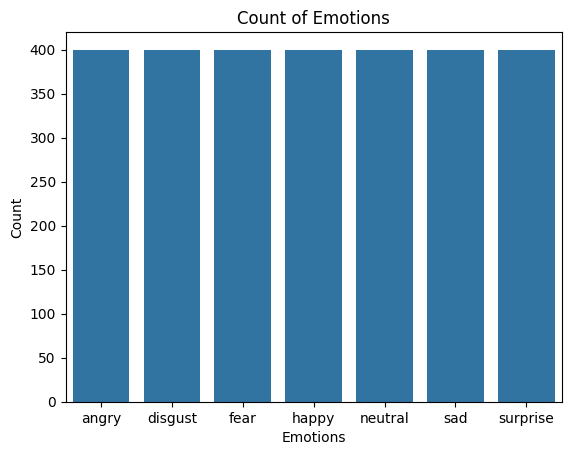

In [21]:
# Convert the 'Emotions' column to a categorical type for better processing
tess_df['emotions'] = tess_df['emotions'].astype('category')

# Plotting the count of emotions
plt.title('Count of Emotions') 
sns.countplot(data=tess_df, x='emotions')  
plt.ylabel('Count')
plt.xlabel('Emotions') 
plt.show()


We can also plot waveplots and spectograms for audio signals
<li> Waveplots - Waveplots let us know the loudness of the audio at a given time
<li> Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It's a representation of frequencies changing with respect to time for given audio/music signals.

In [24]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

# Wave Plots for the Emotions

## <li>Fear

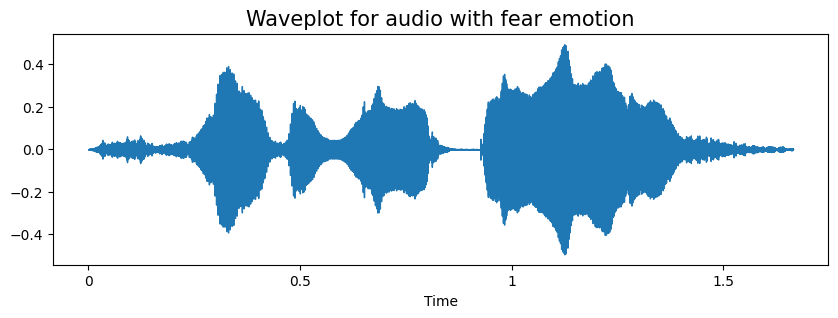

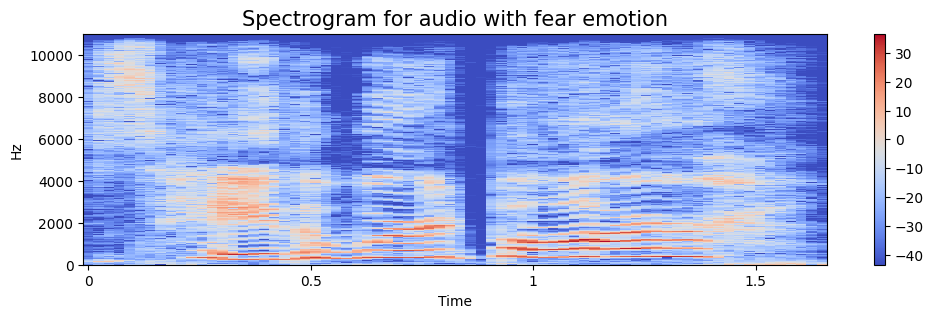

In [25]:
emotion='fear'
path = np.array(tess_df['path'][tess_df['emotions'] == emotion])[0]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## <li>Angry

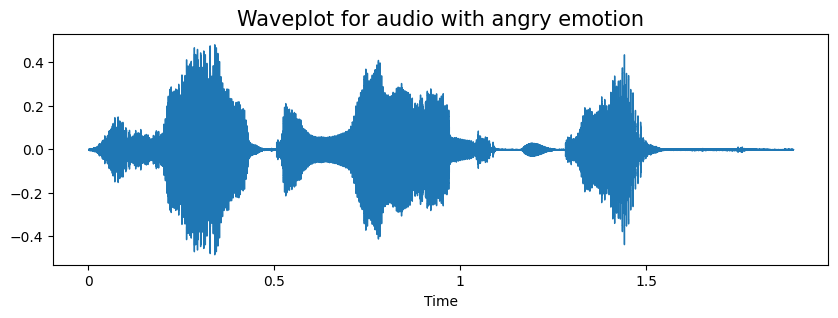

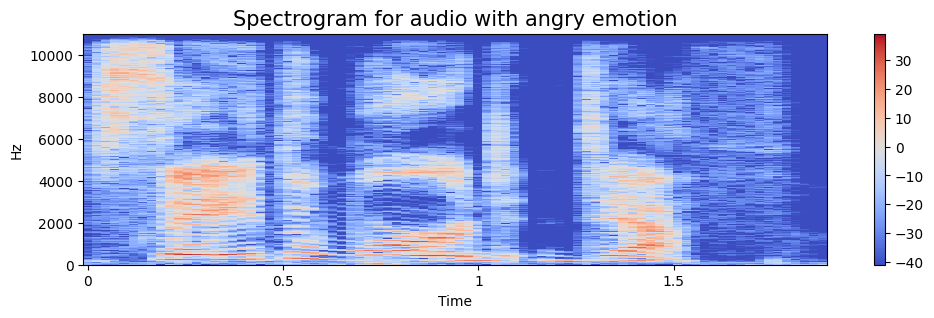

In [26]:
emotion='angry'
path = np.array(tess_df['path'][tess_df['emotions'] == emotion])[0]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## <li>Sad

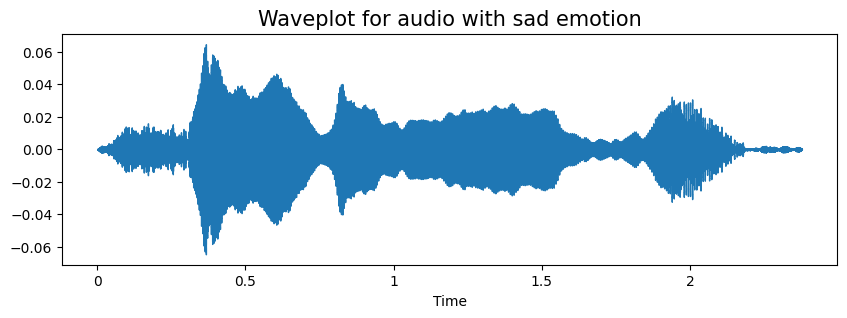

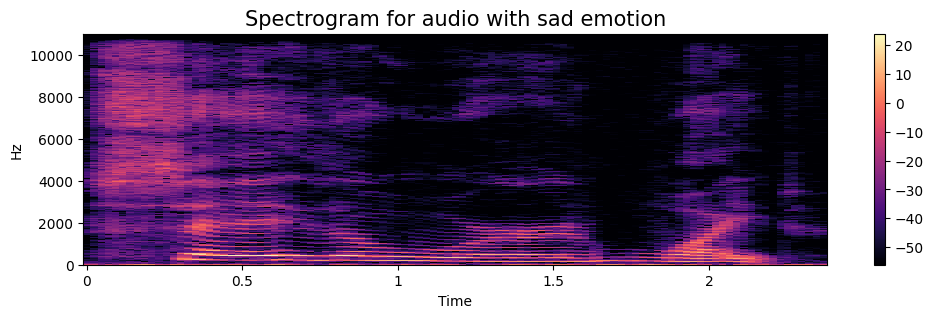

In [27]:
emotion='sad'
path = np.array(tess_df['path'][tess_df['emotions'] == emotion])[0]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## <li>Happy

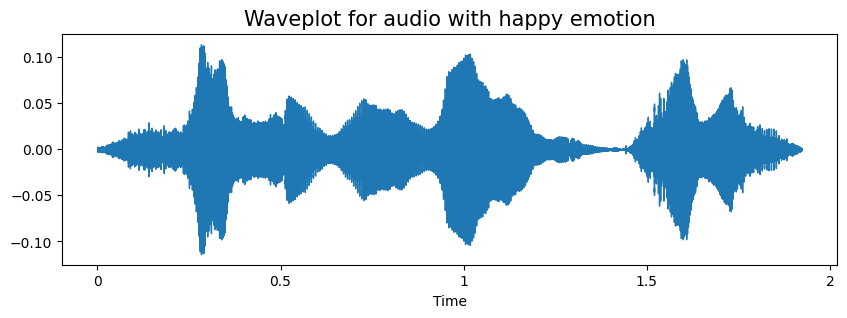

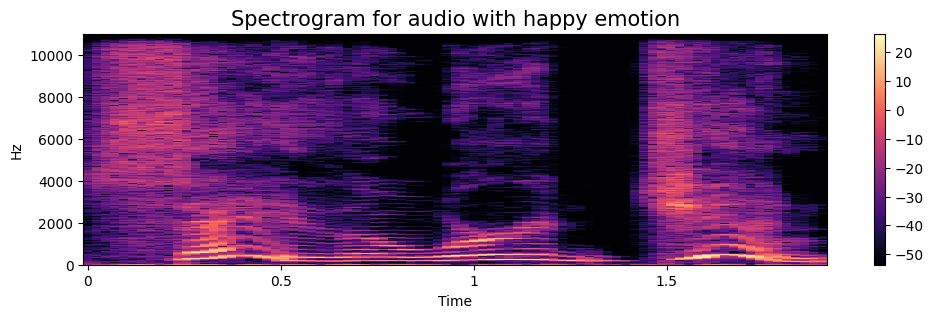

In [28]:
emotion='happy'
path = np.array(tess_df['path'][tess_df['emotions'] == emotion])[0]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data Augmentation
Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.

<li>To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed
<li>The objective is to make our model invariant to those perturbations and enhace its ability to generalize.
<li>In order to this to work adding the perturbations must conserve the same label as the original training sample.
<li>In images data augmention can be performed by shifting the image, zooming, rotating, cropping ...etc

But We need to check which augmentation techinques works better for our dataset

In [33]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

#### 1. Simple Audio

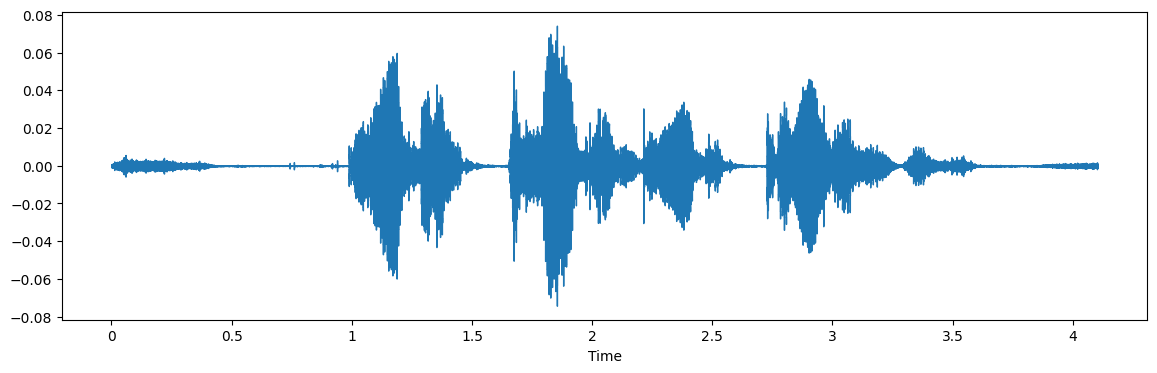

In [34]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

#### 2. Noise Injection

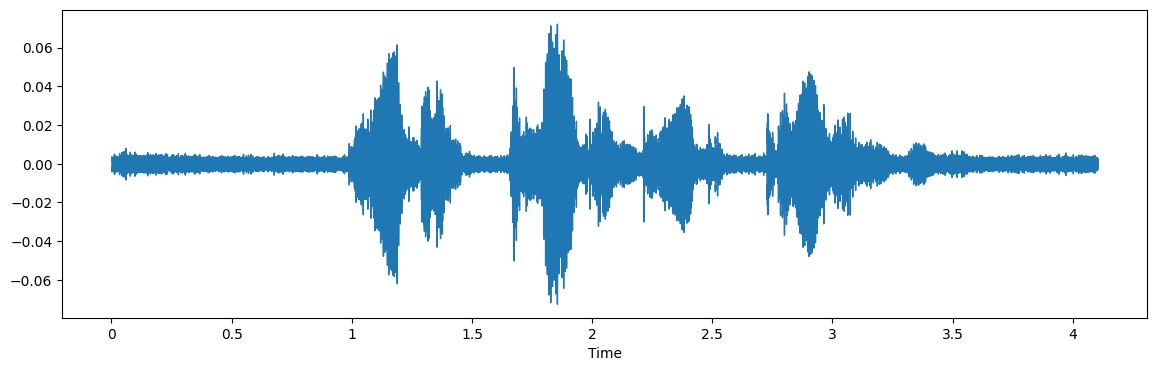

In [35]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

Here, we can see noise injection is a very good augmentation technique because of which we can assure our training model is not overfitted

#### 3.Stretching

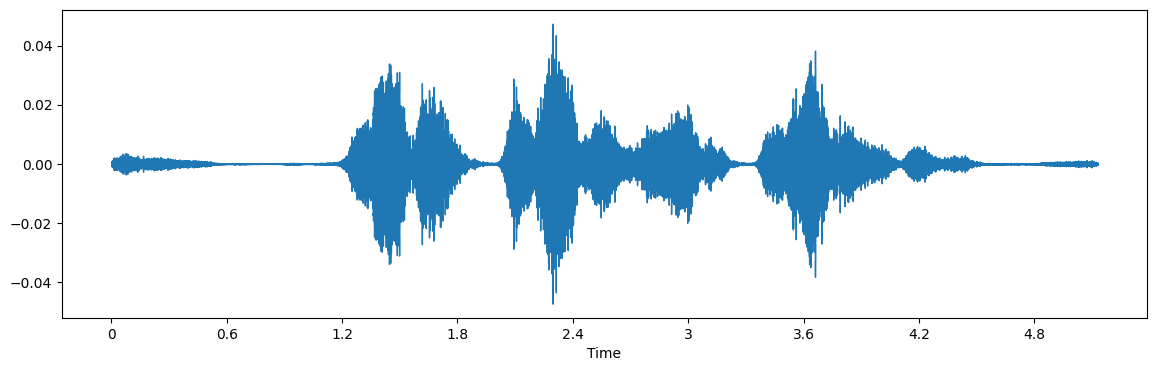

In [36]:
x = stretch(data, rate=0.8)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 4.Shifting

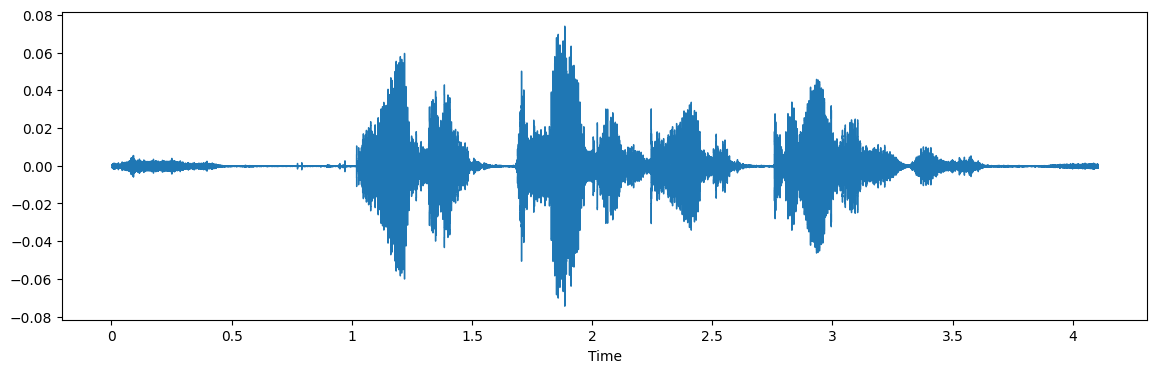

In [37]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 5.Pitch

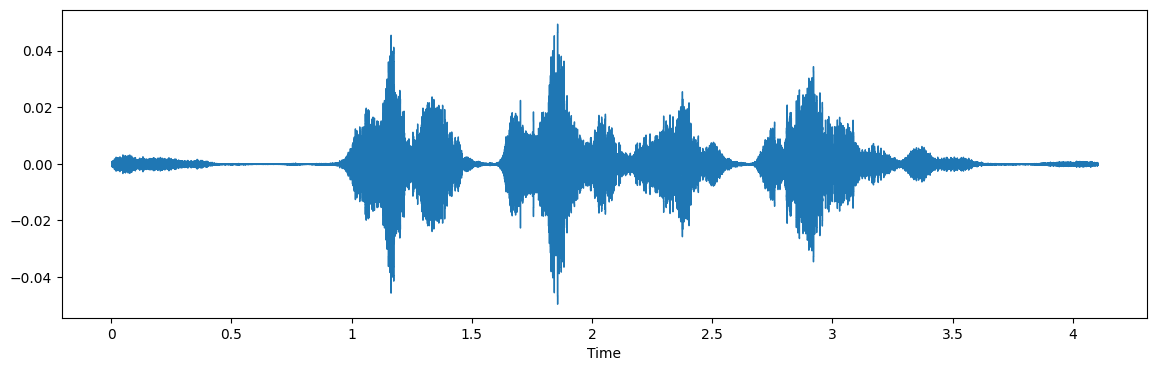

In [38]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

I am employing noise injection, stretching (i.e., changing speed), and pitch modulation as part of the aforementioned augmentation techniques.

## Feature Extraction

In [39]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [40]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [41]:
len(X), len(Y), data_path.Path.shape

(4320, 4320, (1440,))

In [42]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.131058,0.641070,0.640936,0.632723,0.601807,0.578071,0.533593,0.492821,0.544630,0.589397,...,0.025094,0.018035,0.011766,0.012749,0.016679,0.020544,0.014971,0.009265,0.000794,angry
1,0.301455,0.731684,0.749568,0.745728,0.741837,0.713031,0.604668,0.563869,0.611983,0.640272,...,0.070124,0.063918,0.055878,0.055941,0.060997,0.064098,0.059847,0.053063,0.043016,angry
2,0.181044,0.693865,0.610984,0.650573,0.610619,0.580573,0.558241,0.521541,0.534028,0.573120,...,0.004476,0.004638,0.005697,0.003691,0.002377,0.002717,0.003775,0.002357,0.000144,angry
3,0.152312,0.616769,0.668357,0.692952,0.688739,0.678426,0.634658,0.648465,0.693720,0.705390,...,0.000198,0.000278,0.000233,0.000303,0.000524,0.000476,0.000585,0.000407,0.000027,disgust
4,0.242631,0.698201,0.742375,0.769058,0.763910,0.752708,0.680477,0.668484,0.705505,0.704850,...,0.000263,0.000327,0.000286,0.000353,0.000566,0.000526,0.000637,0.000451,0.000077,disgust


We have applied data augmentation and extracted the features for each audio files and saved them.

## Data Preparation

As of now we have extracted the data, now we need to normalize and split our data for training and testing.

In [43]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [44]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [45]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

In [46]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

In [47]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162, 1), (3240, 8), (1080, 162, 1), (1080, 8))

## Modelling

In [48]:
# from tensorflow.keras.optimizers import AdamR
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = "adam", loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1  (None, 81, 256)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 41, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 21, 128)           0

In [50]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=76, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/76
51/51 [==============================] - 1s 27ms/step - loss: 1.0026 - accuracy: 0.6290 - val_loss: 1.2702 - val_accuracy: 0.5315 - lr: 0.0010
Epoch 2/76
51/51 [==============================] - 1s 23ms/step - loss: 0.9682 - accuracy: 0.6414 - val_loss: 1.2797 - val_accuracy: 0.5407 - lr: 0.0010
Epoch 3/76
51/51 [==============================] - 1s 16ms/step - loss: 0.9233 - accuracy: 0.6426 - val_loss: 1.2942 - val_accuracy: 0.5500 - lr: 0.0010
Epoch 4/76
51/51 [==============================] - 1s 16ms/step - loss: 0.9290 - accuracy: 0.6522 - val_loss: 1.2066 - val_accuracy: 0.5602 - lr: 0.0010
Epoch 5/76
51/51 [==============================] - 1s 21ms/step - loss: 0.8749 - accuracy: 0.6707 - val_loss: 1.2692 - val_accuracy: 0.5676 - lr: 0.0010
Epoch 6/76
51/51 [==============================] - 1s 21ms/step - loss: 0.8060 - accuracy: 0.6985 - val_loss: 1.2759 - val_accuracy: 0.5741 - lr: 0.0010
Epoch 7/76
51/51 [==============================] - 1s 23ms/step - loss: 0.7

In [51]:
print("Accuracy of our model on test data : " , model.evaluate(x_train,y_train)*100 , "%")

# epochs = [i for i in range(100)]
# fig , ax = plt.subplots(1,2)
# train_acc = history.history['accuracy']
# train_loss = history.history['loss']
# test_acc = history.history['val_accuracy']
# test_loss = history.history['val_loss']

# fig.set_size_inches(20,6)
# ax[0].plot(epochs , train_loss , label = 'Training Loss')
# ax[0].plot(epochs , test_loss , label = 'Testing Loss')
# ax[0].set_title('Training & Testing Loss')
# ax[0].legend()
# ax[0].set_xlabel("Epochs")

# ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
# ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
# ax[1].set_title('Training & Testing Accuracy')
# ax[1].legend()
# ax[1].set_xlabel("Epochs")
# plt.show()

102/102 [==============================] - 1s 5ms/step - loss: 0.0101 - accuracy: 0.9991
Accuracy of our model on test data :  [0.010116973891854286, 0.9990741014480591, 0.010116973891854286, 0.9990741014480591, 0.010116973891854286, 0.9990741014480591, 0.010116973891854286, 0.9990741014480591, 0.010116973891854286, 0.9990741014480591, 0.010116973891854286, 0.9990741014480591, 0.010116973891854286, 0.9990741014480591, 0.010116973891854286, 0.9990741014480591, 0.010116973891854286, 0.9990741014480591, 0.010116973891854286, 0.9990741014480591, 0.010116973891854286, 0.9990741014480591, 0.010116973891854286, 0.9990741014480591, 0.010116973891854286, 0.9990741014480591, 0.010116973891854286, 0.9990741014480591, 0.010116973891854286, 0.9990741014480591, 0.010116973891854286, 0.9990741014480591, 0.010116973891854286, 0.9990741014480591, 0.010116973891854286, 0.9990741014480591, 0.010116973891854286, 0.9990741014480591, 0.010116973891854286, 0.9990741014480591, 0.010116973891854286, 0.99907410

In [52]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test).reshape(-1, 1)
y_test = encoder.inverse_transform(y_test)

34/34 [==============================] - 1s 11ms/step


In [53]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()
df.head(10)

,Predicted Labels,Actual Labels
0,disgust,disgust
1,happy,happy
2,angry,angry
3,neutral,calm
4,calm,neutral
5,sad,sad
6,surprise,surprise
7,calm,calm
8,neutral,neutral
9,sad,sad


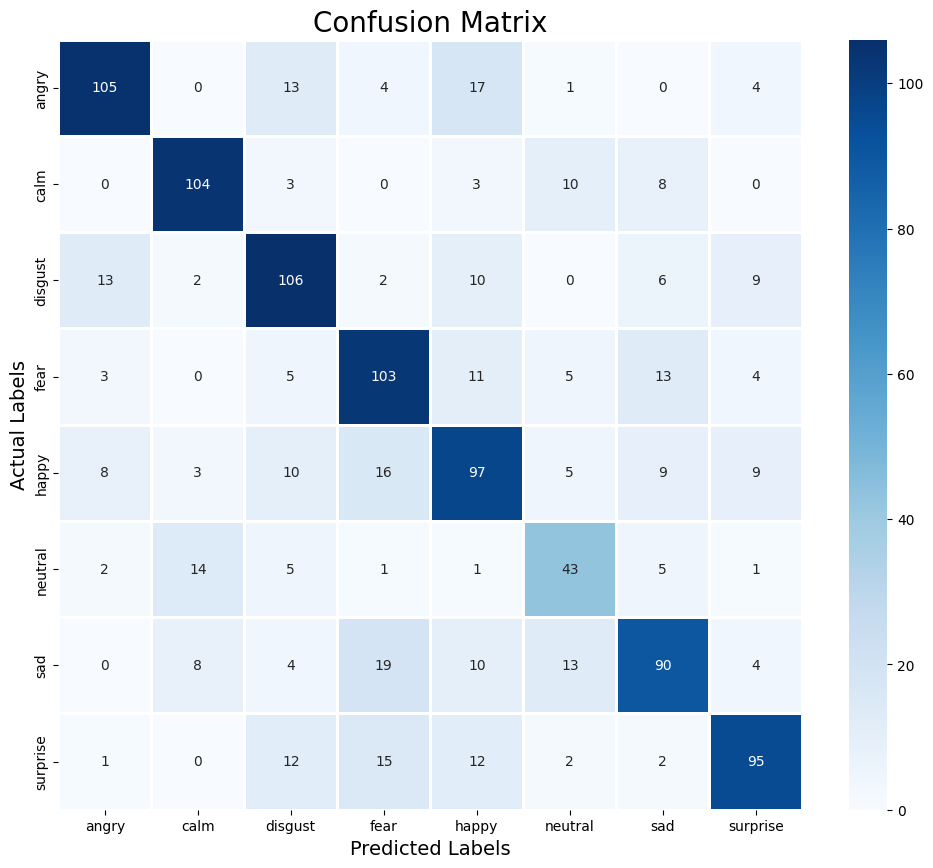

In [54]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [55]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.80      0.73      0.76       144
        calm       0.79      0.81      0.80       128
     disgust       0.67      0.72      0.69       148
        fear       0.64      0.72      0.68       144
       happy       0.60      0.62      0.61       157
     neutral       0.54      0.60      0.57        72
         sad       0.68      0.61      0.64       148
    surprise       0.75      0.68      0.72       139

    accuracy                           0.69      1080
   macro avg       0.69      0.68      0.68      1080
weighted avg       0.69      0.69      0.69      1080



In [56]:
total_instances = np.sum(cm.to_numpy())
correct_predictions = np.trace(cm)

accuracy = correct_predictions / total_instances
print(f'Overall Accuracy: {accuracy:.2%}')

Overall Accuracy: 68.80%


We can see our model is more accurate in predicting surprise, angry emotions and it makes sense also because audio files of these emotions differ to other audio files in a lot of ways like pitch, speed, noise.



We overall achieved 67.87% accuracy on our test data and its decent but we can improve it more by applying more augmentation techniques and using other feature extraction methods.